Epoch [1/30]
Loss: 2.7382, Classification Loss: 1.1484, Domain Loss: 0.0000, Diversity Loss: 1.5898
Epoch [2/30]
Loss: 2.4426, Classification Loss: 0.8953, Domain Loss: 0.0000, Diversity Loss: 1.5473
Epoch [3/30]
Loss: 2.3919, Classification Loss: 0.8166, Domain Loss: 0.0000, Diversity Loss: 1.5753
Epoch [4/30]
Loss: 2.3831, Classification Loss: 0.8019, Domain Loss: 0.0000, Diversity Loss: 1.5812
Epoch [5/30]
Loss: 2.3808, Classification Loss: 0.7814, Domain Loss: 0.0000, Diversity Loss: 1.5993
Epoch [6/30]
Loss: 2.3478, Classification Loss: 0.7500, Domain Loss: 0.0000, Diversity Loss: 1.5978
Epoch [7/30]
Loss: 2.3145, Classification Loss: 0.7003, Domain Loss: 0.0000, Diversity Loss: 1.6142
Epoch [8/30]
Loss: 2.2926, Classification Loss: 0.6838, Domain Loss: 0.0000, Diversity Loss: 1.6088
Epoch [9/30]
Loss: 2.2959, Classification Loss: 0.6755, Domain Loss: 0.0000, Diversity Loss: 1.6204
Epoch [10/30]
Loss: 2.2761, Classification Loss: 0.6591, Domain Loss: 0.0000, Diversity Loss: 1.6171

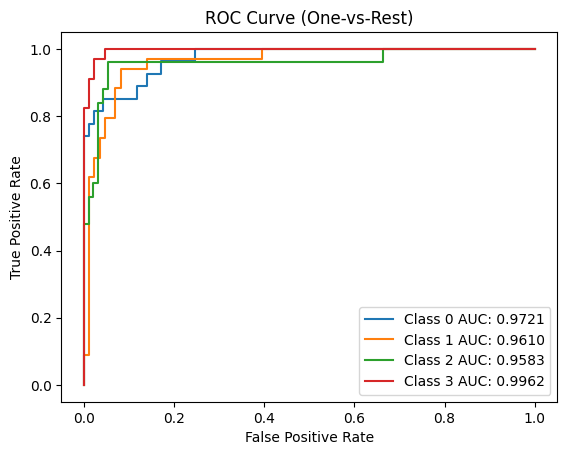

In [2]:
import os
import torch
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch import nn, optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from PIL import Image
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Set the device to CPU (or use 'cuda' if a GPU is available)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load and preprocess the dataset
def load_data(data_dir):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    dataset = datasets.ImageFolder(root=data_dir, transform=transform)
    return dataset

# Load datasets
data_dir = 'C:/Users/HP/Desktop/SAMPLE'  # Change this to your dataset path
dataset = load_data(data_dir)

# Split dataset into training (labeled) and validation (unlabeled)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Define ResNet Feature Extractor
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.resnet = models.resnet18(weights='DEFAULT')
        self.resnet.fc = nn.Identity()  # Remove the fully connected layer

    def forward(self, x):
        return self.resnet(x)

# Define ELM Classifier
class ELMClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(ELMClassifier, self).__init__()
        self.input_size = input_size
        self.num_classes = num_classes
        self.hidden_layer = nn.Linear(input_size, 1000)  # Randomly initialized hidden layer
        self.output_layer = nn.Linear(1000, num_classes)  # Output layer
        self.hidden_weights = torch.randn(1000, input_size)  # Hidden layer weights (H1)
        self.output_weights = None  # Will be calculated during training

    def forward(self, x):
        h = F.relu(self.hidden_layer(x))  # Apply ReLU on hidden layer
        return self.output_layer(h)

    def compute_output_weights(self, h, labels):
        labels = labels.float()
        self.output_weights = torch.linalg.pinv(h) @ labels

# Loss function for domain loss and diversity loss
def compute_losses(source_features, target_features, labels, model):
    domain_loss = F.mse_loss(source_features, target_features)
    classification_loss = F.cross_entropy(model(source_features), labels)
    diversity_loss = -torch.mean(torch.log_softmax(model(source_features), dim=1))
    total_loss = domain_loss + classification_loss + diversity_loss
    return total_loss, classification_loss, domain_loss, diversity_loss

# Training function
def train(model, feature_extractor, train_loader, optimizer, scheduler, num_epochs=30):
    model.train()
    feature_extractor.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        total_classification_loss = 0.0
        total_domain_loss = 0.0
        total_diversity_loss = 0.0
        
        print(f"Epoch [{epoch + 1}/{num_epochs}]")
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            features = feature_extractor(images)
            total_loss, classification_loss, domain_loss, diversity_loss = compute_losses(features, features, labels, model)
            total_loss.backward()
            optimizer.step()

            running_loss += total_loss.item()
            total_classification_loss += classification_loss.item()
            total_domain_loss += domain_loss.item()
            total_diversity_loss += diversity_loss.item()

        scheduler.step()  # Adjust the learning rate
        print(f"Loss: {running_loss / len(train_loader):.4f}, "
              f"Classification Loss: {total_classification_loss / len(train_loader):.4f}, "
              f"Domain Loss: {total_domain_loss / len(train_loader):.4f}, "
              f"Diversity Loss: {total_diversity_loss / len(train_loader):.4f}")

        model.hidden_weights = torch.randn(1000, 512)
        hidden_output = F.relu(model.hidden_layer(features))
        model.compute_output_weights(hidden_output, labels)

# Validation function with precision, recall, F1, and AUC
def validate(model1, model2, feature_extractor, val_loader):
    model1.eval()
    model2.eval()
    feature_extractor.eval()
    total = 0
    correct = 0
    all_labels = []
    all_predictions = []
    all_probabilities = []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            features = feature_extractor(images)
            outputs1 = model1(features)
            outputs2 = model2(features)
            final_output = (outputs1 + outputs2) / 2
            probabilities = torch.softmax(final_output, dim=1)
            _, predicted = torch.max(final_output.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())

    accuracy = 100 * correct / total
    precision = precision_score(all_labels, all_predictions, average='weighted')
    recall = recall_score(all_labels, all_predictions, average='weighted')
    f1 = f1_score(all_labels, all_predictions, average='weighted')
    auc = roc_auc_score(all_labels, all_probabilities, multi_class='ovr')

    print(f"Validation Accuracy: {accuracy:.2f}%")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC: {auc:.4f}")

    for i in range(probabilities.shape[1]):
        fpr, tpr, _ = roc_curve([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probabilities])
        plt.plot(fpr, tpr, label=f"Class {i} AUC: {roc_auc_score([1 if label == i else 0 for label in all_labels], [prob[i] for prob in all_probabilities]):.4f}")
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (One-vs-Rest)')
    plt.legend(loc='best')
    plt.show()

# Initialize models and optimizer
if __name__ == "__main__":
    feature_extractor = FeatureExtractor().to(device)
    elm_classifier1 = ELMClassifier(input_size=512, num_classes=4).to(device)
    elm_classifier2 = ELMClassifier(input_size=512, num_classes=4).to(device)

    optimizer = optim.Adam(list(elm_classifier1.parameters()) + list(elm_classifier2.parameters()), lr=0.001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Train and validate
    train(elm_classifier1, feature_extractor, train_loader, optimizer, scheduler, num_epochs=30)
    validate(elm_classifier1, elm_classifier2, feature_extractor, val_loader)
